In [1]:
import gzip
import pickle
import struct
import os.path

import matplotlib.pyplot as plt
import numpy as np
from array import array as pyarray
from scipy.ndimage import interpolation
from sklearn import svm, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from keras.datasets import mnist

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


# Loading and Process of data

In [4]:
#
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0
test_X = test_X / 255.0

#y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
#
train_X = np.expand_dims(train_X, axis=-1) # <--- add batch axis
test_X = np.expand_dims(test_X, axis=-1) # <--- add batch axis
#
imageShape = train_X[0].shape

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print(imageShape)

X_train: (60000, 28, 28, 1)
Y_train: (60000,)
X_test:  (10000, 28, 28, 1)
Y_test:  (10000,)
(28, 28, 1)


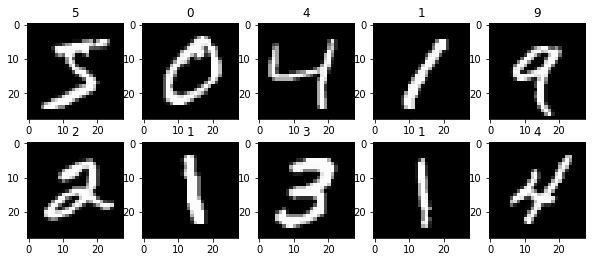

In [6]:
plt.figure(figsize=(10, 4))
nrImage=10
for index, (image, label) in enumerate(zip(train_X[0:nrImage], train_y[0:nrImage])):
	plt.subplot(2, 5, index + 1)
	plt.title(str.format("{0}", label))
	plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
plt.show()

# Common Functions

In [7]:
training_size = len(train_X)
variance = 0.005
varThresh = VarianceThreshold(variance)
high_variance_training_data =  train_X# varThresh.fit(train_X)
high_variance_training_data_size = len(high_variance_training_data)
print(training_size) 
print(high_variance_training_data_size) 

60000
60000


In [8]:
def plotCostHistory(history, loss_label ="", val_label = "", title ="", x_label = "", y_label =""):
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()

# Forward Neuron Network 

In [9]:
def make_forward_neuron_network(shape):
	#
	model = tf.keras.Sequential()
	model.add(layers.Flatten(input_shape=shape))

	model.add(layers.LeakyReLU())
	#model.add(layers.Dropout(0.3))

#	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#	model.add(layers.LeakyReLU())
	model.add(layers.Dropout(0.3))
#	model.add(layers.Flatten())
	model.add(layers.Dense(10))

	return model

In [10]:
BUFFER_SIZE = 256
BATCH_SIZE = 32
EPOCH = 32

forward_neuron_network_model = make_forward_neuron_network(imageShape)
forward_neuron_network_model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(1e-4)



forward_neuron_network_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [11]:
checkpoint_filepath_forward_NN = os.path.join("checkpoints", "mnist_forward_neuron_network_ckpt")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_forward_NN,
    save_weights_only=True,
    monitor='accuracy',
    save_freq='epoch',
    mode='max',
    save_best_only=True)

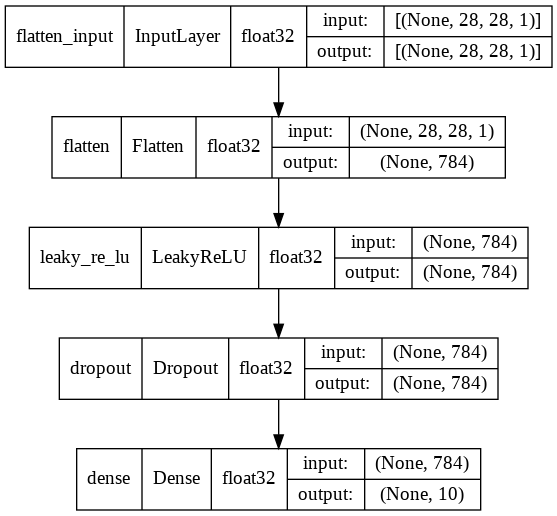

In [12]:
tf.keras.utils.plot_model(
    forward_neuron_network_model, to_file='forward_model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [13]:
forward_nn_history = forward_neuron_network_model.fit(high_variance_training_data, train_y, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])
forward_neuron_network_model.load_weights(checkpoint_filepath_forward_NN)

# Save the model for being reuse in other programs and etc.
forward_neuron_network_model.save('fnn_mnist.h5')

Epoch 1/32
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2643 - accuracy: 0.6593
Epoch 2/32
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6357 - accuracy: 0.8408
Epoch 3/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5075 - accuracy: 0.8652
Epoch 4/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4559 - accuracy: 0.8732
Epoch 5/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4243 - accuracy: 0.8819
Epoch 6/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4057 - accuracy: 0.8865
Epoch 7/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3951 - accuracy: 0.8887
Epoch 8/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3857 - accuracy: 0.8903
Epoch 9/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3769 - accuracy: 0.8912
Epoch 10/32
1875/1875 [==============================] - 3s 2ms/step - loss: 0.370

In [14]:
forward_neuron_network_model.save('fnn_mnist')
forward_neuron_network_model.save("cnn_mnist.h5")

INFO:tensorflow:Assets written to: fnn_mnist/assets


In [15]:
result = forward_neuron_network_model.evaluate(test_X,  test_y, verbose=2)

313/313 - 0s - loss: 0.2787 - accuracy: 0.9234 - 356ms/epoch - 1ms/step


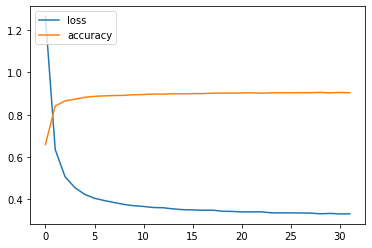

In [16]:
plotCostHistory(forward_nn_history.history)

# Convolution Neuron Network

In [17]:
def make_cnn_model(shape):
	cnn_model = tf.keras.Sequential()
	#
	cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding='same',
							input_shape=shape))
	cnn_model.add(layers.MaxPooling2D((2, 2)))
	#
	cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
	cnn_model.add(layers.MaxPooling2D((2, 2)))
	cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))


	cnn_model.add(layers.Dropout(0.3))

	cnn_model.add(layers.Flatten())
	cnn_model.add(layers.Dense(64, activation='relu'))
	cnn_model.add(layers.Dense(10))
	return cnn_model

In [18]:
BUFFER_SIZE = 256
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(high_variance_training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-4)

cnn_model = make_cnn_model((imageShape[0], imageShape[1], 1))
cnn_model.summary()
cnn_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

checkpoint_filepath = os.path.join("checkpoints", "mnist_convolutional_neuron_network_ckpt")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float64>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                            

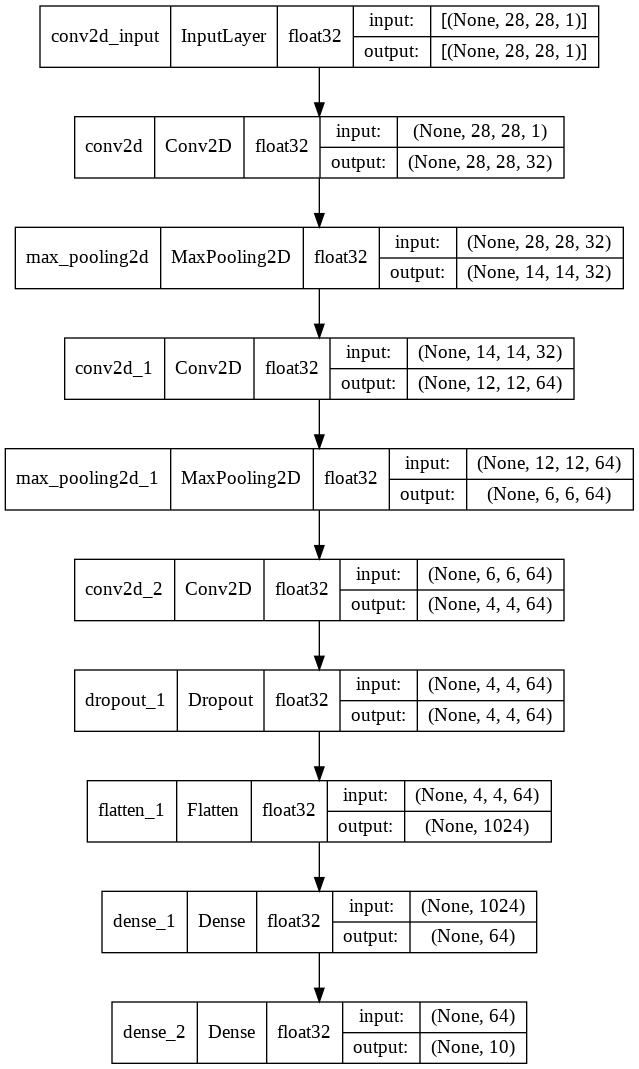

In [19]:
tf.keras.utils.plot_model(
    cnn_model, to_file='cnn_model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [20]:
cnn_model_history = cnn_model.fit(train_X, train_y, epochs=10, validation_data=(test_X, test_y), callbacks=model_checkpoint_callback)
cnn_model.load_weights(checkpoint_filepath)

Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.4382 - accuracy: 0.8670 - val_loss: 0.1201 - val_accuracy: 0.9648
Epoch 2/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1221 - accuracy: 0.9622 - val_loss: 0.0689 - val_accuracy: 0.9798
Epoch 3/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0848 - accuracy: 0.9736 - val_loss: 0.0494 - val_accuracy: 0.9844
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0650 - accuracy: 0.9800 - val_loss: 0.0395 - val_accuracy: 0.9869
Epoch 5/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0558 - accuracy: 0.9829 - val_loss: 0.0367 - val_accuracy: 0.9877
Epoch 6/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0296 - val_accuracy: 0.9901
Epoch 7/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0426 - accuracy: 0.9866 - val_loss: 0.0279 -

In [21]:
cnn_model.save("cnn_mnist.h5")

In [22]:
cnn_model.evaluate(test_X,  test_y, verbose=2)

313/313 - 2s - loss: 0.0255 - accuracy: 0.9916 - 2s/epoch - 8ms/step


[0.025522539392113686, 0.991599977016449]

In [23]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)         

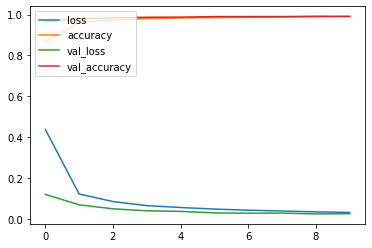

In [24]:
plotCostHistory(cnn_model_history.history)